In [1]:
from typing import Iterable, Tuple
import warnings
from multiprocessing import Pool
from pathlib import Path
import json

import numpy as np  
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize, OptimizeWarning, show_options

# Support for interactive widgets
from IPython.display import *
from ipywidgets import Dropdown

# %matplotlib widget 
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astroquery.simbad import Simbad

from deblib.constants import c

from dust_extinction.parameter_averages import F99, F04, G23

from libs.mistisochrones import MistIsochrones, Phase
from libs.mcmc_sed import ln_prob
from libs import extinction
from libs.sed import get_sed_for_target, create_outliers_mask, group_and_average_fluxes
from libs.sed import create_minimize_target_func, calculate_vfv

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


### Load the PySSED bt-settle model and set up the related SED functions 

__Note:__ The data file is currently a copy of that kindly published on [GitHub](https://github.com/iain-mcdonald/PySSED)
by [McDonald at al., (2024)](https://ui.adsabs.harvard.edu/abs/2024RASTI...3...89M/abstract)

First we load the pre-built data of bt-settle synthetic SED which have previously been parsed
and saved with the `makemodel.py` module. The data file contains fluxes over a range of filters
for combinations of $T_{\rm eff}$, $\log{g}$, $[{\rm Fe/H}]$ and $[{\rm \alpha/Fe}]$. We build a
table in memory which holds a `RegularGridInterpolator` for each filter, with the dimensions/axes
being the $T_{\rm eff}$ and $\log{g}$ values and the values being the corresponding fluxes.

For now we consider only the data for solar metallicity, hence the interpolators only cover
$[{\rm Fe/H}] = 0$ and $[{\rm \alpha/Fe}] = 0$, however additional axes/dimensions
for $[{\rm Fe/H}]$ and $[{\rm \alpha/Fe}]$ may be added, if required.

In [2]:
# Read the pre-built bt-settl model file
model_grid = np.genfromtxt("libs/data/pyssed/model-bt-settl-recast.dat",
                           names=True, delimiter=" ", deletechars=" ~!@#$%^&*()=+~\|]}[{';: ?>,<")

# For now we're only interested in the solar metallicity model fluxes
model_grid = model_grid[(model_grid["metal"] == 0) & (model_grid["alpha"] == 0)]
model_grid.sort(order=["teff", "logg"]) # Should already be in this order, but just in case

# Set up a table of interpolators, one per filter. Each interpolator is based on a pivot table
# with the teffs and loggs as the axes and filter fluxes as the values.
known_filters = list(model_grid.dtype.names)[5:]
teffs, teff_ixs = np.unique(model_grid["teff"], return_inverse=True)
loggs, logg_ixs = np.unique(model_grid["logg"], return_inverse=True)
model_interps = np.empty(shape=(len(known_filters), ), dtype=[("filter", object), ("interp", object)])
for filt_ix, filter in enumerate(known_filters):
    tl_pivot = np.zeros((len(teffs), len(loggs)), dtype=model_grid[filter].dtype)
    tl_pivot[teff_ixs, logg_ixs] = model_grid[filter]
    model_interps[filt_ix] = (filter, RegularGridInterpolator((teffs, loggs), tl_pivot, "linear"))
del model_grid

model_wl_range = (0.3, 22) * u.um
model_teff_range = (min(teffs), max(teffs)) * u.K
model_logg_range = (min(loggs), max(loggs)) * u.dex
print(f"Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:")
print(f"wavelength {model_wl_range}, Teff {model_teff_range} and logg {model_logg_range}")

Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:
wavelength [ 0.3 22. ] um, Teff [ 1900. 70000.] K and logg [-0.5  6. ] dex


This is the `spec_func` for use by the **model_func** during fitting. It interpolates and returns
synthetic SED flux values for chosen filters at the requested $T_{\rm eff}$ and $\log{g}$.

In [3]:
# Helps translates filter names from the SED service to the equivalent filters in model_interps
with open("libs/data/pyssed/sed-filter-translation.json", "r", encoding="utf8") as j:
    sed_filter_translator = json.load(j)

def get_filter_interpolators_and_mappings(filters: Iterable[str]) \
        -> Tuple[Iterable[RegularGridInterpolator], Iterable[int]]:
    """
    Takes the passed list of filters and returns a list of interpolators, one for each unique filter
    listed, and a second list of indices which map these interpolators back to the original list.

    This allows us to avoid repeating this lookup/mapping within a MCMC run.

    :filters: a list of filters to locate and map
    :returns: (list of interpolators, the mappings to the input list)
    """
    # Here np.unique return 2 lists; one of unique values & 2nd of indices mapping them onto input.
    # We use the first list to locate the interpolator corresponding to each unique filter, and we
    # use the second list of indices to map the interpolators onto the output fluxes it generates.
    unique_filters, input_map = np.unique(filters, return_inverse=True)
    interps = np.empty(len(unique_filters), dtype=object)
    for filter_ix, filter in enumerate(unique_filters):
        name = sed_filter_translator.get(filter, filter)
        interps[filter_ix] = model_interps[model_interps["filter"] == name]["interp"][0]
    return interps, input_map

In [4]:
def get_model_fluxes(filter_interps: Iterable[RegularGridInterpolator],
                     flux_mappings: Iterable[int],
                     teff: float,
                     logg: float) -> Iterable[float]:
    """
    Will return a ndarray of flux values calculated by the filters corresponding to the
    interpolators. The filter_interps and flux_mappings are effectively the return values
    from the get_filter_interpolators_and_mappings() function. This is separated out to avoid
    repeating the same lookup for every attempted fit.

    It's not obvious in the data file, but the scale of the values implies the fluxes are in Jy

    :filter_interps: unique list of interpolators to use to generate flux values
    :flux_mappings: mapping indices from the interpolators onto the output
    :teff: the effective temperature for the fluxes
    :logg: the logg for the fluxes
    """
    # Generate each unique flux value
    xi = (teff, logg)
    fluxes_by_filter = np.empty((len(filter_interps)), dtype=float)
    for filter_flux_ix, filter in enumerate(filter_interps):
        fluxes_by_filter[filter_flux_ix] = filter(xi=xi)

    # Copy the fluxes to the output via the mappings
    return_fluxes = np.empty((len(flux_mappings)), dtype=float)
    for flux_ix, flux_mapping in enumerate(flux_mappings):
        return_fluxes[flux_ix] = fluxes_by_filter[flux_mapping]
    return return_fluxes

In [5]:
# Test the above
test_filters = ['Johnson:V', 'Gaia:G', 'Gaia:G', '2MASS:J', 'Johnson:J', 'Johnson:J', 'Johnson:H',
                '2MASS:H', '2MASS:Ks', 'Johnson:K', 'WISE:W1', 'WISE:W3', 'WISE:W3']
filter_interps, flux_mappings = get_filter_interpolators_and_mappings(test_filters)
fluxes = get_model_fluxes(filter_interps, flux_mappings, 5750., 4.44)
print(fluxes)

[8.26772e+18 8.82360e+18 8.82360e+18 1.04926e+19 1.04820e+19 1.04820e+19
 9.29786e+18 9.28118e+18 6.24596e+18 6.18728e+18 2.89262e+18 2.55888e+17
 2.55888e+17]


### Set up the extinction model

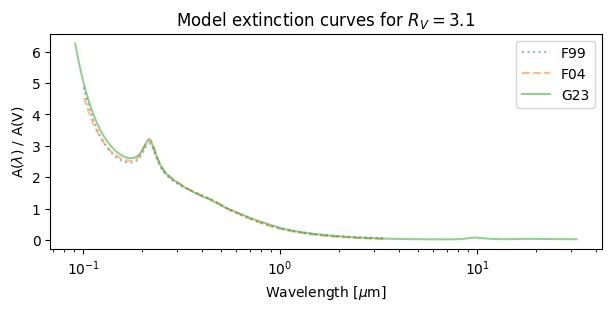

Using the G23 extinction model covers the range from 0.0912 um to 32.0 um.


In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
for (_mod, _ls) in [(F99, ":"), (F04, "--"), (G23, "-")]:
    _lambda = (1 / np.logspace(*np.log10(_mod.x_range), num=1000)) * u.um
    ax.plot(_lambda, _mod(Rv=3.1)(_lambda), ls=_ls, alpha=0.5, label=f"{_mod.name}")
ax.set(title=f"Model extinction curves for $R_V=3.1$", xscale="log",
       xlabel=r"Wavelength [$\mu$m]", ylabel=r"A($\lambda$) / A(V)")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

# The G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model covers the range from",
      f"{min(ext_wl_range)} to {max(ext_wl_range)}.")

### Select our target and get its known information

In [7]:
default_target = "CM Dra"
targets_config_file = Path.cwd() / "config" / "fitting-a-sed-targets.json"
with open(targets_config_file, mode="r", encoding="utf8") as f:
    full_dict = json.load(f)
targets_cfg = { k: full_dict[k] for k in full_dict if full_dict[k].get("enabled", True) }

max_teff = max(model_teff_range).value
options = [
    (f"{t}" + (" *" if c.get("exclude", False) else "") + (" [too hot!]" if min(c["TeffA"], c["TeffB"]) > max_teff else ""), t)
        for t, c in targets_cfg.items()
]

target_selection = Dropdown(options=options, value=default_target, description="Targets:")
display(target_selection)

Dropdown(description='Targets:', index=31, options=(('V436 Per', 'V436 Per'), ('V539 Ara', 'V539 Ara'), ('MU C…

In [8]:
target = target_selection.value
target_config = targets_cfg[target]
search_term = target_config.get("search_term", target)
k, k_err = target_config.get("k"), target_config.get("k_err", 0)

# initial Temps for fitting. For now known values rounded to nearest 100 K
teffs0 = np.round(np.array([target_config["TeffA"], target_config["TeffB"]]) / 100) * 100

# We need the coordinates and approximate distance for extinction lookups
simbad = Simbad()
simbad.add_votable_fields("parallax")
if _tbl := simbad.query_object(search_term):
    target_coords = SkyCoord(ra=_tbl["ra"][0] * _tbl["ra"].unit,
                             dec=_tbl["dec"][0] * _tbl["dec"].unit,
                             distance=1000 / _tbl["plx_value"][0] * u.pc)
    print(f"{target} SkyCoords are {target_coords}")

CM Dra SkyCoords are <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (248.58470944, 57.1623247, 14.86157925)>


### Get the SED data for the target
- apply default uncertainties to those measurements with none
- remove duplicate SED measurements
- group and average SED measurements by filter & frequency
- exclude measurements outside the range of our extinction model
- exclude flux outliers

In [9]:
# Read in the SED for this target and de-duplicate (measurements may appear multiple times).
sed = get_sed_for_target(target, search_term, radius=0.1, remove_duplicates=True, verbose=True)

sed = group_and_average_fluxes(sed, verbose=True)

# Filter SED to those covered by our models and also remove any outliers
model_mask = np.ones((len(sed)), dtype=bool)
model_mask &= np.array([f in sed_filter_translator for f in sed["sed_filter"]])
model_mask &= (sed["sed_wl"] >= min(ext_wl_range)) & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(model_wl_range)) & (sed["sed_wl"] <= max(model_wl_range))
sed = sed[model_mask]

out_mask = np.zeros_like(model_mask[model_mask], dtype=bool)
#out_mask |= create_outliers_mask(sed, teffs0, min_unmasked=15, verbose=True)
sed = sed[~out_mask]
print(f"{len(sed)} unique SED observation(s) retained after range and outlier filtering")

Opened SED table containing 28 row(s).
Removing 10 duplicate row(s).
Grouped SED by ['sed_filter', 'sed_freq'] yielding 9 group(s) from 18 row(s).
Calculating the group means of the [('sed_flux', 'sed_eflux')] columns
8 unique SED observation(s) retained after range and outlier filtering


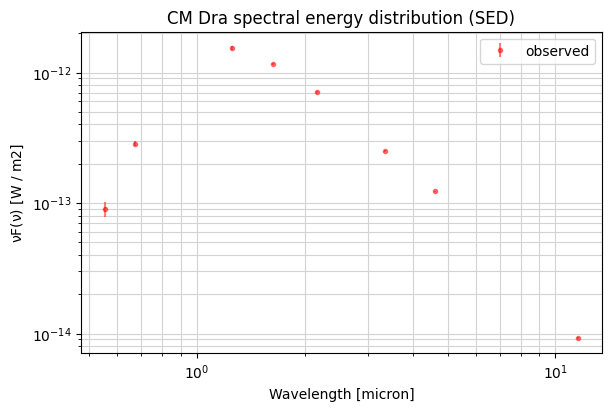

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
vfv, evfv = calculate_vfv(sed)
ax.errorbar(sed["sed_wl"], vfv, evfv, fmt=".r", alpha=0.5, label="observed")
ax.set(title=f"{target} spectral energy distribution (SED)",
       xscale="log", xlabel=f"Wavelength [{sed['sed_wl'].unit}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{vfv.unit}]")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### De-redden the SED
Use the target coordinates to find an $E(B-V)$ value from the available extinction maps.
With this we can deredden the remaining SED fluxes using the previously created extinction model. 

In [11]:
for val, flags in extinction.get_extinction(target_coords):
    if val and not np.isnan(val) and flags.get("converged", False):
        print(f"Found extinction with {flags['source']}: {flags.get('type', '')} = {val:.6f}")
        if flags.get("type", "") == "B(B-V)":
            sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=val)
        else:
            sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Av=val)
        break

if "sed_der_flux" in sed.colnames:
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

Found extinction with get_gontcharov_ebv: E(B-V) = 0.015330


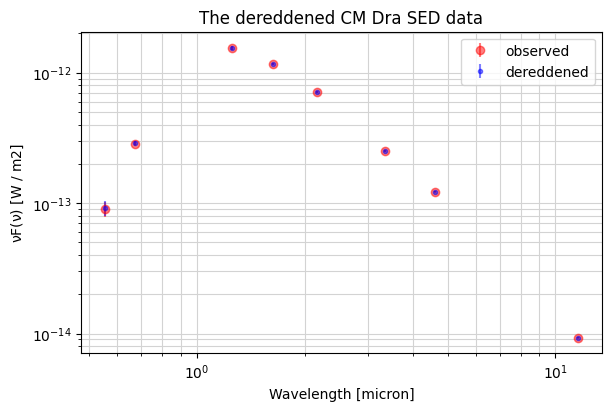

In [12]:
vfv, evfv = calculate_vfv(sed, flux_colname="sed_flux")
der_vfv, der_evfv = calculate_vfv(sed, flux_colname="sed_der_flux")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed["sed_wl"], vfv, evfv, fmt="or", alpha=0.5, label="observed")
ax.errorbar(sed["sed_wl"], der_vfv, der_evfv, fmt=".b", alpha=0.5, label=der_lab)
ax.set(title=f"The dereddened {target} SED data",
       xscale="log", xlabel=f"Wavelength [{sed['sed_wl'].unit}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{der_vfv.unit}]")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### Run the fit

Here we set up `theta0` which is our 'best guess' of the $T_{\rm eff}$ and $\log{g}$ values
for the system based on existing published data and the light-curve fitting carried out previously.

In [13]:
if target == "CM Dra":
    light_ratio, teff_sys, logg = 0.869, 3214, 5.0
elif target == "CW Eri":
    light_ratio, teff_sys, logg = 0.455, 6861, 4.0
elif target == "ZZ Boo":
    light_ratio, teff_sys, logg = 1.131, 6775, 4.0
elif target == "ZZ UMa":
    light_ratio, teff_sys, logg = 0.350, 5865, 4.0
else:
    light_ratio = 10**(target_config.get("logLB", 1) - target_config.get("logLA", 1))
    teff_sys = round(target_config.get("TeffA", 6000) / 100) * 100
    logg = 4.0

theta0 = [teff_sys, teff_sys * (light_ratio / k**2)**.25, logg, logg]
print(f"For {target} theta0 = {', '.join(f'{t:.3f}' for t in theta0)}")

For CM Dra theta0 = 3214.000, 3192.162, 5.000, 5.000


Now we can set up the known priors and the **prior_func** which will be called during minimization
to return True or False depending on whether the current `theta` conforms to these criteria, or not.

In [14]:
MIN_TEFF, MAX_TEFF = model_teff_range.value

# We can probably set some range based on SpT and evolutionary phase (ie: if k < 1 -> M-S)
MIN_LOGG, MAX_LOGG = 3.0, 5.5

# Target specific priors
teff_ratio = theta0[1] / theta0[0]
teff_flex = teff_ratio * 0.05
print(f"Priors from initial values: TeffB/TeffA={teff_ratio:.6f} +/- flex of {teff_flex:.6f}")

def prior_func(theta) -> bool:
    return all(MIN_LOGG < l < MAX_LOGG for l in theta[2:]) \
        and all(MIN_TEFF < t < MAX_TEFF for t in theta[:2]) \
        and abs(theta[1]/theta[0] - teff_ratio) < teff_flex

Priors from initial values: TeffB/TeffA=0.993205 +/- flex of 0.049660


The **model_func** will calculate a set of model SED flux data at points `x` for the current `theta`.
The implementation `scaled_summed_model(x, theta)` scales these model data to the known SED
fluxes before returning them.

In [15]:
# These are the functions for generating synthetic spectra and combining them into a model
# Dangerous to ignore x for direct access to filter_interps & flux_mappings, but faster
filter_interps, flux_mappings = get_filter_interpolators_and_mappings(sed["sed_filter"])
flux_unit = sed["sed_der_flux"].unit
y_log = np.log10(sed["sed_der_flux"].value)

def scaled_summed_model(x, theta):
    teffA, teffB, loggA, loggB = theta
    # Scale the model to the obs' in log10 space as the range of potential values is very wide
    y_model_log = np.log10(np.add(get_model_fluxes(filter_interps, flux_mappings, teffA, loggA),
                                  get_model_fluxes(filter_interps, flux_mappings, teffB, loggB)))
    if flux_unit != u.Jy:
        y_model_log -= 26
    return 10**(y_model_log + np.median(y_log - y_model_log))

Now we create the function which scipy can `minimize`. This function will:
- call `prior_func(theta)` to evaluate the current set params (`theta`) against prior criteria
- if the `prior_func` returns True
    - call `scaled_summed_model(x, theta)` to calculate the `y_model` data at `x` based on the
    current `theta`
    - call the default `sim_func(y_model, y, y_err)` implementation to calculate a single value
    summarizing the goodness of fit
    - returns the result of `sim_func`
- if the `prior_func` returns False
    - `np.inf` is returned

The call to scipy's `minimize` will optimize `theta` to minimize the value returned from `sim_func`.
It starts at `theta0`, which is our 'best guess' starting position for this system, and returns
the final fitted `theta` values from which the model data achieves the best result from `sim_func`.

In [16]:
target_func = create_minimize_target_func(sed["sed_freq"].value,
                                          sed["sed_der_flux"].value,
                                          sed["sed_eflux"].value,
                                          scaled_summed_model,
                                          prior_func)

METHOD = None # Let minimize choose
# show_options("minimize", METHOD, disp=True)

with warnings.catch_warnings(category=[RuntimeWarning, OptimizeWarning]):
    warnings.filterwarnings("ignore", message="invalid value encountered in subtract")
    warnings.filterwarnings("ignore", message="Desired error not necessarily achieved due to precision loss.")
    soln = minimize(target_func, x0=theta0, method=METHOD, options={ "disp": True })
    #print(soln)
    theta = soln.x

         Current function value: 106.935809
         Iterations: 0
         Function evaluations: 48
         Gradient evaluations: 8


In [17]:
teffA, teffB, loggA, loggB = theta

print(f"Best fit parameters for {target} from minimization fit")
for val, p, unit in [(teffA, "TeffA", u.K), (teffB, "TeffB", u.K), 
                     (loggA, "loggA", u.dex), (loggB, "loggB", u.dex)]:
    print(f"{p:>9s} = {val:.3f} {unit}",
          f"(known value {target_config.get(p, np.NaN)} +/- {target_config.get(p+'_err', '')})")

Best fit parameters for CM Dra from minimization fit
    TeffA = 3214.000 K (known value 3130 +/- 70)
    TeffB = 3192.162 K (known value 3120 +/- 70)
    loggA = 5.000 dex (known value nan +/- )
    loggB = 5.000 dex (known value nan +/- )


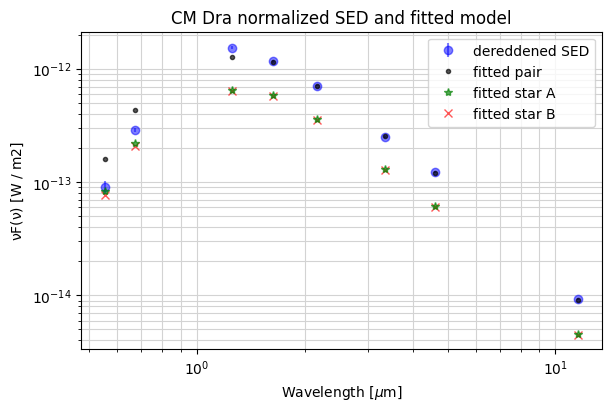

In [18]:
# The baseline dereddened observed SED data in nu*F(nu) form
obs_der_vfv, obs_der_evfv = calculate_vfv(sed, flux_colname="sed_der_flux")

# Generate a model SED from the fitted values in nu*F(nu) form for plotting
raw_mod_fluxes = np.array([get_model_fluxes(filter_interps, flux_mappings, teffA, loggA),
                           get_model_fluxes(filter_interps, flux_mappings, teffB, loggB)])
flux_ratio_A = raw_mod_fluxes[0] / np.add(*raw_mod_fluxes)
sed_freq = sed["sed_freq"].value
mod_comb_vfv = scaled_summed_model(sed_freq, theta) * sed_freq
mod_starA_vfv = mod_comb_vfv * flux_ratio_A
mod_starB_vfv = mod_comb_vfv * (1 - flux_ratio_A)

# Plot the fitted model against the derredened SED + show each star's contribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
for (lam,           flux,               eflux,              fmt,    alpha,  z,      label) in [
    (sed["sed_wl"], obs_der_vfv,        obs_der_evfv,       "ob",   0.5,    50,     "dereddened SED"),
    (sed["sed_wl"], mod_comb_vfv,       None,               ".k",   0.66,   90,     "fitted pair"),
    (sed["sed_wl"], mod_starA_vfv,      None,               "*g",   0.66,   80,     "fitted star A"),
    (sed["sed_wl"], mod_starB_vfv,      None,               "xr",   0.66,   70,     "fitted star B"),
]:
    ax.errorbar(lam, flux, eflux, fmt=fmt, alpha=alpha, zorder=z, label=label)
ax.set(title=f"{target} normalized SED and fitted model", xscale="log", yscale="log",
       xlabel=r"Wavelength [$\mu$m]", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{obs_der_vfv.unit}]")
ax.grid(True, which="both", axis="both", color="lightgray", zorder=0)
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)